# Simple Inference

In [61]:
%matplotlib inline
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.sandbox.stats.runs as sssr
from scipy import optimize, stats

In [62]:
sns.set(color_codes=True)

## Estimating the Width of a Room

_Shortly after metric units of length were officially introduced in Australia in the 1970s, each of a group of 44 students was asked to guess, to the nearest meter, the width of the lecture hall in which they were sitting. Another group of 69 students in the same room was asked to guess the width in feet, ot the nearest foot. The main question is whether estimation in feet and in meters gives different results._

In [63]:
roomwidth = pd.read_csv('roomwidth.csv')
del roomwidth['Unnamed: 0']
roomwidth.head()

,unit,width
0,metres,8
1,metres,9
2,metres,10
3,metres,10
4,metres,10


In [64]:
def convert(row):
    if row['unit'] == 'metres':
        row['width'] *= 3.28
    return row

roomwidth = roomwidth.apply(convert, axis=1)
roomwidth.head()

,unit,width
0,metres,26.24
1,metres,29.52
2,metres,32.80
3,metres,32.80
4,metres,32.80


In [65]:
roomwidth[roomwidth['unit'] == 'metres'].describe()

,width
count,44.000000
mean,52.554545
std,23.434443
min,26.240000
25%,36.080000
50%,49.200000
75%,55.760000
max,131.200000


In [66]:
roomwidth[roomwidth['unit'] == 'feet'].describe()

,width
count,69.000000
mean,43.695652
std,12.497417
min,24.000000
25%,36.000000
50%,42.000000
75%,48.000000
max,94.000000


In [67]:
print(
    round(roomwidth[roomwidth['unit'] == 'feet']['width'].std(), 1), 
    round(roomwidth[roomwidth['unit'] == 'metres']['width'].std(), 1),
)

12.5 23.4


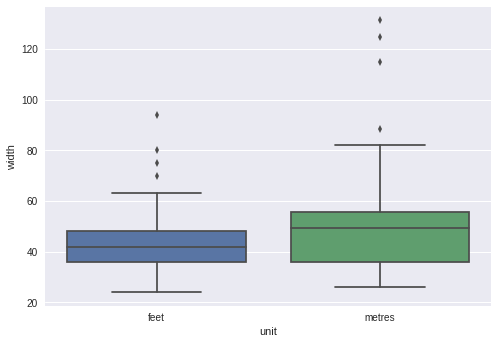

In [68]:
sns.boxplot(x="unit", y="width", data=roomwidth, order=['feet', 'metres'])

_The boxplots indicate that both sets of estimates contain a number of outliers and also that the estimates made in meters are skewed and more variable than those made in feet, a point underlined by the numerical summary statistics above. Both normal probability plots depart from linearity, suggesting that the distributions of both sets of estimates are not normal. The presence of outliers, the apparently different variances and the evidence of non-normality all suggest caution in applying the t-test, but for the moment we shall apply the usual version of the test._

In [69]:
roomfeet = roomwidth[roomwidth['unit'] == 'feet']
roommetres = roomwidth[roomwidth['unit'] == 'metres']

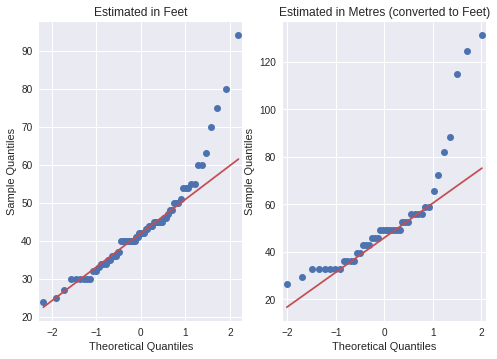

In [70]:
fig, ax = plt.subplots(ncols=2)
sm.qqplot(roomfeet['width'], ax=ax[0], line='q')
ax[0].set_title("Estimated in Feet")
sm.qqplot(roommetres['width'], ax=ax[1], line='q')
ax[1].set_title("Estimated in Metres (converted to Feet)")
plt.show()

In [71]:
tvalue, pvalue = stats.ttest_ind(
    a=roomfeet['width'],
    b=roommetres['width'],
)
print("Student t-test")
print("t-value", tvalue, "p-value", pvalue, "df", (len(roomfeet['width']) + len(roommetres['width']) - 2))

print("mean in group feet", roomfeet['width'].mean())
print("mean in group metres", roommetres['width'].mean())

cm = sms.CompareMeans.from_data(roomfeet['width'], roommetres['width'])
cil, cir = cm.tconfint_diff(usevar='pooled')
print("confidence interval", cil, cir)

Student t-test
t-value -2.6146714459 p-value 0.0101717231777 df 111
mean in group feet 43.6956521739
mean in group metres 52.5545454545
confidence interval -15.5727343089 -2.14505225235


In [72]:
tvalue, pvalue = stats.ttest_ind(
    a=roomwidth[roomwidth['unit'] == 'feet']['width'],
    b=roomwidth[roomwidth['unit'] == 'metres']['width'],
    equal_var=False,
)
print("Welch t-test")
print("t-value", tvalue, "p-value", pvalue)

print("mean in group feet", roomfeet['width'].mean())
print("mean in group metres", roommetres['width'].mean())

cm = sms.CompareMeans.from_data(roomfeet['width'], roommetres['width'])
cil, cir = cm.tconfint_diff(usevar='unequal')
print("confidence interval", cil, cir)

Welch t-test
t-value -2.30706887773 p-value 0.0245917766133
mean in group feet 43.6956521739
mean in group metres 52.5545454545
confidence interval -16.5430765962 -1.17470996507


_But this form of t-test assumes both normality and equality of population variances, both of which are suspect for these data. Departure from the equality of variance assumption can be accommodated by the modified t-test described above and this can be applied by choosing_ `equal_var=False`. _The result above indicates that there is strong evidence for a difference in the means of the two types of estimates._

_But there remains the problem of the outliers and the possible non-normality; consequently we shall apply the Wilcoxon Mann-Whitney test which, since it is based on the ranks of the observations, is unlikely to be affected by the outliers, and which does not assume that the data have a normal distribution._

In [73]:
U, pvalue = stats.mannwhitneyu(roomfeet['width'], roommetres['width'])
print("U", U, "p-value", pvalue)

U 1145.0 p-value 0.0140773944076


_A two-sided p-value_ `0.014 * 2 = 0.028` _confirms the difference in location of the two types of estimates of room width. Note that, due to ranking the observations, the confidence interval for the median difference reported here is much smaller than the confidence interval for the differenece in means in both t-tests._

In [74]:
def wilcoxon_cint(x, y):
    """
    An attempt to calculate confidence interval of Wilcoxon test, based on it's R implementation:
    https://github.com/wch/r-source/blob/trunk/src/library/stats/R/wilcox.test.R
    """
    n = len(x)
    mu = 0
    conf_level = 0.95
    exact = len(x) < 50

    r = stats.rankdata((x - mu).append(y))
    n_x = len(x)
    n_y = len(y)
    exact = (n_x < 50) and (n_y < 5)
    statistic = np.sum(r[0:n_x]) - n_x * (n_x + 1) / 2
    ties = (len(r) != len(np.unique(r)))

    # https://github.com/wch/r-source/blob/trunk/src/library/stats/R/wilcox.test.R#L332
    nties = pd.Series(r).value_counts()
    z = statistic - (n_x * n_y / 2)
    sigma = np.sqrt((n_x * n_y / 12) *
                    ((n_x + n_y + 1)
                   - np.sum(np.power(nties, 3) - nties)
                    / ((n_x + n_y) * (n_x + n_y - 1))))
    correction = np.sign(z) * 0.5
    z = (z - correction) / sigma
    pval = 2 * min(stats.norm.cdf(z), stats.norm.cdf((1 - z) / 2))
    assert round(pval, 3) == round(2 * pvalue, 3)  # This just verifies we're on the right track.

    # conf.int
    alpha = 1 - conf_level
    mumin = x.min() - y.max()
    mumax = x.max() - y.min()

    def W(d):
        dr = stats.rankdata((x - d).append(y))
        nties_ci = pd.Series(r).value_counts()
        dz = np.sum(dr[0:n_x]) - n_x * (n_x + 1) / 2 - n_x * n_y / 2
        correction_ci = np.sign(dz) * 0.5
        sigma_ci = np.sqrt((n_x * n_y / 12) *
                               ((n_x + n_y + 1)
                             - sum(np.power(nties_ci, 3) - nties_ci)
                             / ((n_x + n_y) * (n_x + n_y - 1))))
        return (dz - correction_ci) / sigma_ci

    def wdiff(d, zq):
        val = W(d) - zq
        return val
    
    Wmumin = W(mumin)
    Wmumax = W(mumax)

    def root(zq):
        lower = Wmumin - zq
        if lower <= 0:
            return mumin
        upper = Wmumax - zq
        if upper >= 0:
            return mumax
        return optimize.brentq(wdiff, a=mumin, b=mumax, args=(zq,))

    l = root(zq=stats.norm.ppf(1 - alpha / 2))
    u = root(zq=stats.norm.ppf(alpha / 2))
    
    return (l, u)

l, u = wilcoxon_cint(roomfeet['width'], roommetres['width'])
print("95 percent confidence interval")
print(l, u)

95 percent confidence interval
-9.359999999999618 -0.8000000000008245


*Note:* Above result does not exactly (digit for digit) match R (`-9.3599953 -0.8000423`), but is close enough

### Summary of Findings

Guessing the width of the room in different units results in a statistically significant (`p-value = 0.028 < 0.05`) difference in the means of the guesses in feet and those in meters (after conversion to feet). The estimates made in feet are between 16 and 2 feet smaller on average (from confidence intervals of both t-tests) than those made in meters.

## Wave Energy Device Mooring

_This data requires the use of a matched pairs t-test to answer the question of interest. This test assumes that the differences between the matched observations have a normal distribution so we can begin by checking this assumption by constructing a boxplot and a normal probability plot._

In [75]:
waves = pd.read_csv('waves.csv')
del waves['Unnamed: 0']
waves.head()

,method1,method2
0,2.23,1.82
1,2.55,2.42
2,7.99,8.26
3,4.09,3.46
4,9.62,9.77


In [76]:
mooringdiff = waves['method1'] - waves['method2']

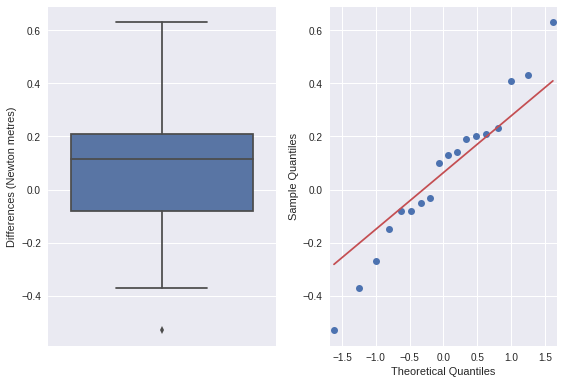

In [77]:
fig, ax = plt.subplots(ncols=2)
sns.boxplot(y=mooringdiff, ax=ax[0]).set_ylabel("Differences (Newton metres)")
sm.qqplot(mooringdiff, ax=ax[1], line='q')
plt.tight_layout()
plt.show()

_The boxplot indicates a possible outlier, and the normal probability plot gives little cause for concern about departures from normality, although with only 18 observations it is perhaps difficult to draw any convincing conclusion. We can now apply the paired t-test to the data._

In [78]:
tvalue, pvalue = stats.ttest_1samp(mooringdiff, popmean=0.0)
print("t-value", tvalue, "p-value", pvalue)

ds = sms.DescrStatsW(mooringdiff)
l, u = ds.tconfint_mean()
print("confidence interval", l, u)

t-value 0.90193418101 p-value 0.379693422795
confidence interval -0.0825847617698 0.205918095103


### Summary of Findings

There is no evidence that the two mooring methods differ in their effect on the bending stress (`p-value > 0.05`).

## Mortality and Water Hardness

_To begin we will construct a scatterplot of the data enhanced somewhat by the addition of information about the marginal distributions of water hardness and mortality, and by adding the estimated linear regression fit for mortality on hardness._

In [79]:
water = pd.read_csv('water.csv')
del water['Unnamed: 0']
water.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


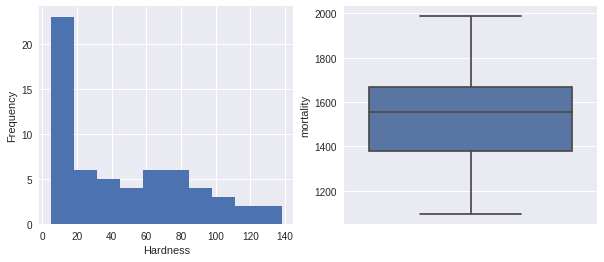

In [80]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
water['hardness'].hist(ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Hardness")
sns.boxplot(y=water['mortality'], ax=ax[1])

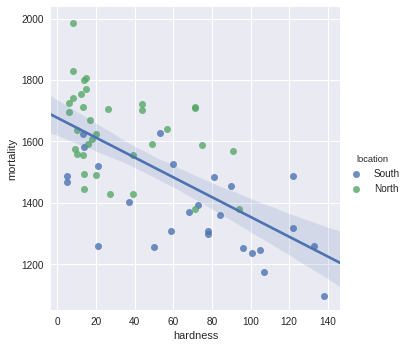

In [81]:
g = sns.lmplot(x="hardness", y="mortality", hue="location", data=water, fit_reg=False)
sns.regplot(x="hardness", y="mortality", data=water, scatter=False, ax=g.axes[0, 0])

_The scatterplot shows that as hardness increases mortality decreases, and the histogram for the water hardness shows it has a rather skewed distribution._

_We can both calculate the Pearson's correlation coefficient between the two variables and test whether it differs significantly for zero._

In [82]:
np.corrcoef(water['mortality'], water['hardness'])

array([[ 1.        , -0.65484862],
       [-0.65484862,  1.        ]])

In [83]:
t, pvalue = stats.pearsonr(water['mortality'], water['hardness'])

print("t", t, "pvalue", pvalue)

t -0.654848623204 pvalue 1.03313392603e-08


_The estimated correlation is_ `-0.6548` _and is highly significant_ (`1.033e-08 < 0.05`).

### Summary of Findings

The scatterplot of mortality against hardness shows that increasing hardness is associated with decreasing mortality and that the relationship between the two variables is essentially linear. There is a statistical significant correlation between water hardness and mortality with the sample correlation being -0.65.

## Piston Ring Failures

In [84]:
pistonrings = pd.read_csv('pistonrings.csv')
pistonrings.rename(index=str, columns={'Unnamed: 0': 'compressor'}, inplace=True)
pistonrings.set_index('compressor')
pistonrings.head()

,compressor,North,Centre,South
0,C1,17,17,12
1,C2,11,9,13
2,C3,11,8,19
3,C4,14,7,28


_The first step in the analysis of_ `pistonrings` _data is to apply the chi-squared test for independence._

In [85]:
chi2, pvalue, dof, expected = stats.chi2_contingency(pistonrings[['North', 'Centre', 'South']])

def chi2_residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

print("chi-squared", chi2, "p-value", pvalue, "dof", dof)
print("residuals")
residuals = chi2_residuals(pistonrings[['North', 'Centre', 'South']], expected)
pd.concat([pistonrings[['compressor']], residuals], axis=1).head()

chi-squared 11.7222663711 p-value 0.0684593607257 dof 6
residuals


,compressor,North,Centre,South
0,C1,0.603615,1.672827,-1.780224
1,C2,0.142903,0.297520,-0.347120
2,C3,-0.325143,-0.452262,0.620246
3,C4,-0.415789,-1.466694,1.463523


_The value of chi-squared test statistic is 11.72 with 6 degrees of freedom and an associated p-value of 0.068. The evidence for departure from independence of compressor and leg is not strong, but it may be worthwile taking the analysis a little further by examining the estimated expected values and the differences of these from the corresponding observed value - residuals._

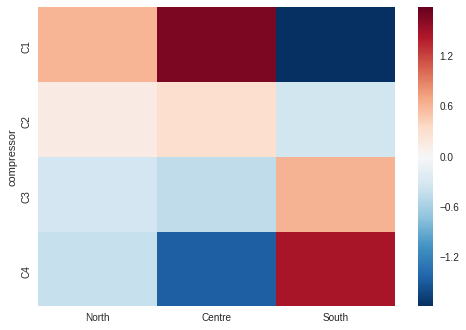

In [86]:
sns.heatmap(pd.concat([pistonrings[['compressor']], residuals], axis=1).set_index('compressor'))

_The largest deviations from indepence are for C1 and C4 compressors in the center and south leg._

### Summary of Findings

The chi-squared test for the independence of leg and compressor is not statistically significant and there is no compelling evidence for any departure from independence in the size of the residuals.

## Rearrests of Juveniles

In [87]:
rearrests = pd.read_csv('rearrests.csv')
multiindex = pd.MultiIndex.from_tuples([
    ('Juvenile court', 'Rearrest'),
    ('Juvenile court', 'No rearrest'),
])
rearrests.rename(index=str, columns={'Unnamed: 0': 'Adult court'}, inplace=True)
rearrests = rearrests.set_index('Adult court')
rearrests = pd.DataFrame(rearrests.as_matrix(), columns=multiindex, index=rearrests.index)
rearrests.head()

Juvenile court            
                  Rearrest No rearrest
Adult court                           
Rearrest               158         515
No rearrest            290        1134

_Here we need to use McNemar's test to assess whether rearrest is associated with the type of court where the juvenile was tried. An [explanation](https://stats.stackexchange.com/questions/76875/what-is-the-difference-between-mcnemars-test-and-the-chi-squared-test-and-how) of how McNemar's test is different from chi-squared test._

In [88]:
statistic, pvalue = sssr.mcnemar(x=rearrests, exact=False, correction=False)

print("McNemar's Chi-squared test")
print("statistic", statistic, "p-value", pvalue)

McNemar's Chi-squared test
statistic 62.8881987578 p-value 2.18779160729e-15


_The test statistic is 62.89 with associated p-value is extremely small and there is strong evidence that type of court and the probability of rearrest are related. It appears that trial at a juvenile court is less likely to result in rearrest. An exact version of McNemar's test can be obtained by testing using exact binomial test._

In [89]:
statistic, pvalue = sssr.mcnemar(x=rearrests, exact=True, correction=False)

print("Binomial exact test")
print("statistic", statistic, "p-value", pvalue)

Binomial exact test
statistic 290 p-value 1.9178889945e-15


### Summary of Findings

The application of McNemar's test gives very clear evidence that handling juvenile felons in juvenile rather than adult courts results in a lower proportion of rearrests.

# Exercises

## Ex. 3.1

_After the students had made the estimates of the width of the lecture hall the room width was accurately measured and found to be 13.1 meters (43.0 feet). Use this additional information to determine which of the two types of estimates was more precise._

In [90]:
actualwidth_feet = 43.0

precision_feet = np.sqrt(np.sum(np.power(actualwidth_feet - x, 2) for x in roomfeet['width']) / len(roomfeet['width']))
precision_fmetres = np.sqrt(np.sum(np.power(actualwidth_feet - x, 2) for x in roommetres['width']) / len(roommetres['width']))

print("feet            : {} +- {}".format(roomfeet['width'].mean(), precision_feet))
print("metres (in feet): {} +- {}".format(roommetres['width'].mean(), precision_fmetres))

feet            : 43.69565217391305 +- 12.426012920540895
metres (in feet): 52.55454545454545 +- 25.05955379418469


### Summary of Findings

Estimates in feet were more precise.

## Ex. 3.2

_For the mortality and water hardness data calculate the correlation between the two variables in each region, north and south._

In [91]:
corr_north = water[water['location'] == 'North']['mortality'].corr(water[water['location'] == 'North']['hardness'])
corr_south = water[water['location'] == 'South']['mortality'].corr(water[water['location'] == 'South']['hardness'])

print("Correlation in the North:", corr_north)
print("Correlation in the South:", corr_south)

Correlation in the North: -0.368597838329
Correlation in the South: -0.602153271548


### Summary of Findings

Correlation in the South is bigger.

## Ex. 3.3

_The standardized residuals calculated for the piston ring data are not entirely satisfactory for the reasons given in the text. An alternative residual suggested by Haberman (1973) is defined as the ration of the standardized residuals and an adjustment:_

$\dfrac{\sqrt{(n_{jk} - E_{jk})^2 / E_{jk}}}{\sqrt{(1 - n_{j\cdot} / n)(1 - n_{\cdot k} / n)}}$

_When the variables forming the contingency table are independent, the adjusted residuals are approximately normally distributed with mean zero and standard deviation one. Write a function to calculate both standardized and adjusted residuals for any RxC contingency table and apply it to the piston ring data._

In [92]:
pistonrings = pistonrings.set_index('compressor')
pistonrings.head()

,North,Centre,South
compressor,,,
C1,17,17,12
C2,11,9,13
C3,11,8,19
C4,14,7,28


In [126]:
def haberman_residuals(df):
    colsums = df.sum(axis=0)
    rowsums = df.sum(axis=1)
    dftotal = colsums.sum()

    expected_values = pd.DataFrame([[x * y / dftotal for x in colsums] for y in rowsums], index=df.index, columns=df.columns)

    def _formula(row, col):
        return (np.sqrt(np.power(df.ix[row][col] - expected_values.ix[row][col], 2) / expected_values.ix[row][col])
            / np.sqrt((1 - colsums[col] / dftotal) * (1 - rowsums[row] / dftotal)))

    return pd.DataFrame(
        [[_formula(row, col) for col in df.columns] for row in df.index],
        index=df.index,
        columns=df.columns,
    )

haberman_residuals(pistonrings)

,North,Centre,South
compressor,,,
C1,0.860476,2.267323,2.782456
C2,0.193502,0.383039,0.515344
C3,0.448785,0.593524,0.938649
C4,0.600273,2.013259,2.316599


## Ex. 3.4

_For the data in table_ `rearrests` _estimate the difference between the probability of being rearrested after being tried in an adult court and in a juvenile court, and find a 95% confidence interval for the population difference._

In [127]:
rearrests

Juvenile court            
                  Rearrest No rearrest
Adult court                           
Rearrest               158         515
No rearrest            290        1134

In [138]:
rearreststotal = rearrests.sum().sum()

p1 = (158 + 515) / rearreststotal
p2 = (158 + 290) / rearreststotal

print("probability of being rearrested after being tried in an adult court  :", p1)
print("probability of being rearrested after being tried in a juvenile court:", p2)

def chi2_confidence_interval(obs):
    n1, n2 = obs.sum(axis=1)
    prop1 = obs.as_matrix()[0, 0] / n1
    prop2 = obs.as_matrix()[0, 0] / n2
    delta = prop1 - prop2
    
    standard_error = np.sqrt(prop1 * (1 - prop1) / n1 + prop2 * (1 - prop2) / n2)
    ci = (delta - 1.96 * standard_error, delta + 1.96 * standard_error)
    
    correction = 0.5 * (1 / n1 + 1 / n2)
    cci = (ci[0] - correction, ci[1] + correction)
    
    return ci, cci

ci, _ = chi2_confidence_interval(rearrests)
ci

print("95% confidence interval: ", round(ci[0], 4), round(ci[1], 4))

probability of being rearrested after being tried in an adult court  : 0.320934668574
probability of being rearrested after being tried in a juvenile court: 0.213638531235
95% confidence interval:  0.0879 0.1598


## Ex. 3.5



_The data in_ `ETF` _were collected from a sample of 24 primary school children. Each child completed the Embedded Figures Test (EFT), which measures 'field dependence', i.e., the extent to which a person can abstract the logical structure of a problem from its context. Then the children were allocated to one of two experimental groups. They were timed as they constructed a 3x3 pattern from nine colored blocks, taken from the Wechsler Intelligence Scale for children (WISC). The two experimental groups differed in the instructions they were given for the test: the 'row group' were told to start with a row of three blocks and the 'corner group' were told to start with a corner of three groups. The experimenter was interested in whether the different instructions produced any change in the average time to complete the pattern and in whether this time was affected by field dependence. See what light you can throw on these questions using any of the graphical and inference techniques discussed to this point._

In [141]:
eft = pd.read_csv('EFT.csv')
del eft['Unnamed: 0']
eft.head()

,group,time,EFT
0,row,317,59
1,row,464,33
2,row,525,49
3,row,298,69
4,row,491,65


In [142]:
eft.describe()

,time,EFT
count,24.000000,24.000000
mean,384.291667,55.458333
std,126.411502,33.932131
min,196.000000,7.000000
25%,297.250000,31.000000
50%,371.000000,49.000000
75%,470.750000,66.000000
max,739.000000,139.000000


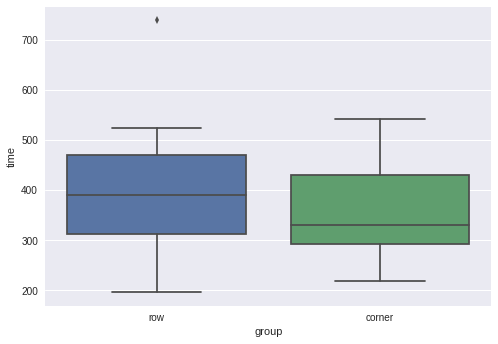

In [143]:
sns.boxplot(x='group', y='time', data=eft)

The boxplot gives impression that children from 'corner group' were slightly faster to complete the pattern.

IQR boxes are roughly the same height, that would suggest equal variances.

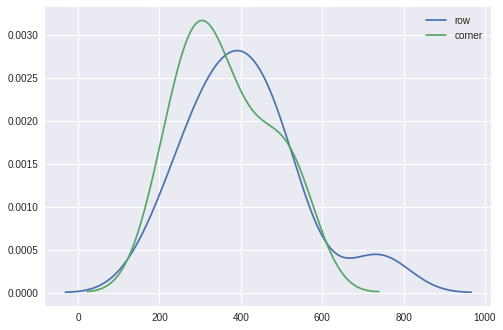

In [144]:
fig, ax = plt.subplots()
sns.kdeplot(data=eft[eft['group'] == 'row']['time'], ax=ax, legend=True)
sns.kdeplot(data=eft[eft['group'] == 'corner']['time'], ax=ax)

ax.legend(["row", "corner"])

Both look like a normal distribution.

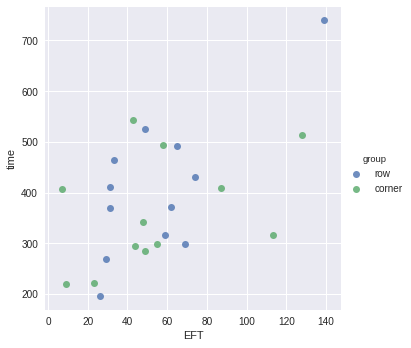

In [145]:
sns.lmplot(x="EFT", y="time", hue="group", data=eft, fit_reg=False)

Can't tell anything from the scatterplot.

In [146]:
eftrow = eft[eft['group'] == 'row']
eftcorner = eft[eft['group'] == 'corner']
tvalue, pvalue = stats.ttest_ind(
    a=eftrow['time'],
    b=eftcorner['time'],
)
print("Student t-test")
print("t-value", tvalue, "p-value", pvalue, "df", (len(eftrow) + len(eftcorner) - 2))

print("mean in group row", eftrow['time'].mean())
print("mean in group corner", eftcorner['time'].mean())

Student t-test
t-value 0.862277431784 p-value 0.397837002224 df 22
mean in group row 406.666666667
mean in group corner 361.916666667


p-value = 0.40, which is more than 0.05, therefore we cannot reject the null hypothesis: $H_0: \mu_{row} = \mu_{corner}$ and cannot claim that a significant difference exists between the times it takes to complete the test for two different groups. 

### Summary of Findings

There is no statistically significant difference between the time it takes to complete the test for the two groups of children.